In [2]:
#Import Libraries
import folium
from folium.features import GeoJsonTooltip
import pandas as pd
import numpy as np

import plotly.express as px
import geopandas as gpd
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import branca.colormap as cm
import geojsoncontour
from folium.plugins import FloatImage
from copy import deepcopy

In [3]:
#Read the geoJSON file using geopandas
geojson = gpd.read_file(r'drafts/centroids_wgs.geojson')
df_grid=pd.read_csv(r'../4_2-grid-congestion-peaks/off_peak_above_100.csv')

df_merge = geojson.merge(df_grid, left_on="polygon_id", right_on="cell_id", how="outer") 
df_merge = df_merge[~df_merge['geometry'].isna()]
df_merge.dropna(inplace = True)

In [4]:
df_merge['speedDiff%'] = [round(i) for i in df_merge['speedDiff%']]

In [5]:
df_multiplies = pd.DataFrame()
for index,row in df_merge.iterrows():
    multiplier = row['speedDiff%']
    df_multiplies = df_multiplies.append([row]*multiplier, ignore_index=True)

## Grid

In [6]:
# min and max for coordinates
minLat = 44.96282106687191
minLon = 7.502048016422193
maxLat = 45.19265016665321 
maxLon = 7.791812422724604

In [7]:
tmp= list(df_merge['cell_id'].str.split('_'))
x_num = len(np.unique(np.array(tmp)[:,0].astype(int)))
y_num = len(np.unique(np.array(tmp)[:,1].astype(int)))

In [8]:
#building a grid of point for sampling the resulting KDEs
xx = np.linspace(minLon, maxLon, x_num)
yy = np.linspace(minLat, maxLat, y_num)

xg, yg = np.meshgrid(xx,yy)
grid_coords = np.c_[xg.ravel(), yg.ravel()]

## KDE

In [9]:
kde_cols = ['centroid_lon','centroid_lat']

bandwidth = .001 #approx 100m
# bandwidths = [.0005,.001,.00150,.002,.0025,.003,.0035]
# bandwidths = [.0005,.001]
# bandwidths = [.001]

In [10]:
#train model
model = KernelDensity( metric="euclidean",kernel="gaussian",bandwidth=bandwidth).fit(df_multiplies[kde_cols])
kde_samples = np.exp(model.score_samples(grid_coords).reshape(*xg.shape))

/opt/anaconda3/envs/bigdatalab_cpu_202208/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  "X does not have valid feature names, but"


In [11]:
colors = ['black','orange','red']

In [12]:
m = folium.Map(location=[45.0703,7.6869], zoom_start=12,overlay=False,tiles='openstreetmap')

In [13]:
threshold = 74
kde_samples[kde_samples<threshold] = 0
levels = np.array(0)
levels = np.append(levels,np.linspace(threshold, kde_samples.max(), 4))
levels = [round(l,2) for l in levels]
colorScale = cm.LinearColormap(colors, vmin=round(kde_samples.min(),2), 
                               vmax=round(kde_samples.max(),2)).to_step(index=levels)
colorScale

In [14]:
levels

[0.0, 74.0, 96.37, 118.74, 141.11]

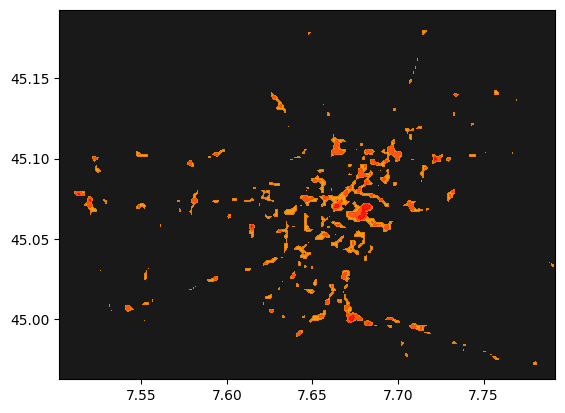

In [15]:
colorScale.caption = f'Score Sample of bandwidth = {bandwidth}'
colorScale.add_to(m)
contourf = plt.contourf(xg, yg, kde_samples,levels = levels, alpha=0.9,colors = colorScale.colors)

# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=.5,
    fill_opacity=1)

folium_geo = folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':  1,
    }).add_to(m)
    # maps.append(m)
    # geojsons.append(geojson)

In [16]:
m

In [48]:
for i,m in enumerate(maps):
    m.save(f"bandwidth_{bandwidths[i]}.html")
